In [37]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import losses
from tensorflow.keras import datasets
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import random

In [18]:
def preprocess(images):
    images = images.astype('float32') / 255.0
    images = np.pad(images, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    images = np.expand_dims(images, -1)
    return images

In [19]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

x_train = preprocess(x_train)
x_test = preprocess(x_test)

## Build Sampling layer

In [6]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build Encoder Network

In [9]:
encoder_input = layers.Input(
    shape=(32, 32, 1), name='encoder_input'
)
x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(2, name='z_mean')(x)
z_log_var = layers.Dense(2, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')

## Build Decoder Network

In [10]:
decoder_input = layers.Input(
    shape=(2,), name='decoder_input'
)
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation='relu', padding='same'
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation='relu', padding='same'
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation='sigmoid',
    padding='same',
    name='decoder_output'
)(x)

decoder = models.Model(decoder_input, decoder_output)

## Define Variational AutoEncoder class

In [14]:
class VAE(models.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')
    
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        recostruction = self.decoder(z)
        return z_mean, z_log_var, recostruction
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                500
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis = 1,
                )
            )

            total_loss = reconstruction_loss + kl_loss

            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)

            return {m.name: m.result() for m in self.metrics}

# Train model

In [22]:
vae = VAE(encoder, decoder)

In [23]:
vae.compile(optimizer='adam')

In [24]:
vae.fit(x_train, epochs=5, batch_size=100)

Epoch 1/5
600/600 [==============================] - 669s 1s/step - total_loss: 152.6733 - reconstruction_loss: 148.0887 - kl_loss: 4.5846
Epoch 2/5
600/600 [==============================] - 254s 424ms/step - total_loss: 134.6448 - reconstruction_loss: 129.5998 - kl_loss: 5.0451
Epoch 3/5
600/600 [==============================] - 267s 445ms/step - total_loss: 133.1503 - reconstruction_loss: 128.0061 - kl_loss: 5.1444
Epoch 4/5
600/600 [==============================] - 276s 460ms/step - total_loss: 132.3753 - reconstruction_loss: 127.1473 - kl_loss: 5.2280
Epoch 5/5
600/600 [==============================] - 248s 414ms/step - total_loss: 131.7785 - reconstruction_loss: 126.4978 - kl_loss: 5.2806


## Explore results

In [34]:
x_test_encoded = encoder.predict(x_test)[0]

313/313 [==============================] - 9s 29ms/step


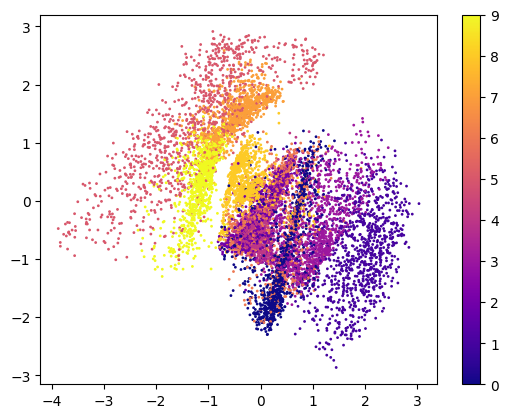

In [35]:
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, s=1, cmap='plasma')
plt.colorbar()

### Images and their reconstructions

1/1 [==============================] - 0s 75ms/step


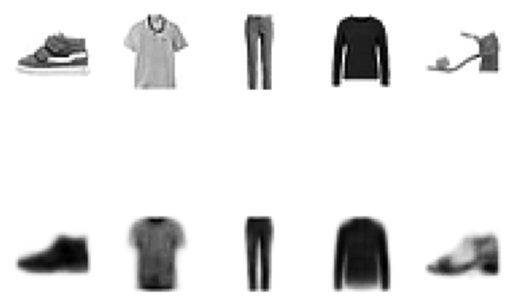

In [48]:
num_elems = 5

fig, axs = plt.subplots(2, num_elems)

for c in range(num_elems):
    img_idx = random.randint(0, x_test.shape[0]-1)

    real_img = x_test[[img_idx], :].reshape((32, 32))
    reconstructed_img = vae.predict(real_img.reshape((1, 32, 32, 1)))[2].reshape((32, 32))

    plt.sca(axs[0, c])

    plt.imshow(real_img, cmap='binary')
    plt.axis('off')

    plt.sca(axs[1, c])

    plt.imshow(reconstructed_img, cmap='binary')
    plt.axis('off')



### Generate new samples

In [49]:
max_x, max_y = np.max(x_test_encoded, axis=0)
min_x, min_y = np.min(x_test_encoded, axis=0)

1/1 [==============================] - 0s 33ms/step


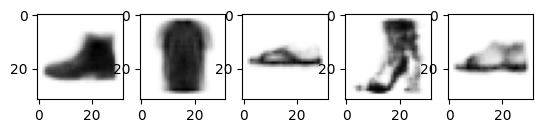

In [55]:
num_elems = 5

fig, axs = plt.subplots(1, num_elems)

for i in range(num_elems):
    x_pos, y_pos = random.uniform(min_x, max_x), random.uniform(min_y, max_y)
    gen_img = decoder.predict(np.array([x_pos, y_pos]).reshape((1, -1)))
    gen_img = gen_img.reshape((32, 32))
    plt.sca(axs[i])
    plt.imshow(gen_img, cmap='binary')

plt.show()